In [1]:
!mkdir train
!mkdir train/NORMAL
!mkdir train/PNEUMONIA
!mkdir val
!mkdir val/NORMAL
!mkdir val/PNEUMONIA
!mkdir test
!mkdir test/NORMAL
!mkdir test/PNEUMONIA

In [2]:
import os
import shutil
import pickle
with open('/kaggle/input/photos/photos.pickle', 'rb') as f:
    photos=pickle.load(f)
print(photos['train_normal'][0])

4056cac3-6aef-4e85-b40d-166f86811ca4.dcm


In [3]:
source_dir='/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
for x in photos['train_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['train_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['val_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['val_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['test_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['test_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/PNEUMONIA/', x)
  shutil.copy(src, dst)


In [4]:

normal_images = os.listdir('train/NORMAL')
pneumonia_images = os.listdir('train/PNEUMONIA')
print('Тренировочная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()

normal_images = os.listdir('val/NORMAL')
pneumonia_images = os.listdir('val/PNEUMONIA')

print('Валидационная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()


normal_images = os.listdir('test/NORMAL')
pneumonia_images = os.listdir('test/PNEUMONIA')

print('Тестовая выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))


Тренировочная выборка:
Без пневмонии  16024
C пневмонией  4660

Валидационная выборка:
Без пневмонии  3099
C пневмонией  901

Тестовая выборка:
Без пневмонии  1549
C пневмонией  451


In [5]:
from tqdm import tqdm
import pydicom
from PIL import Image

def convert_dicom_to_jpeg(input_folder, output_folder):
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.dcm'):
            dicom_file = os.path.join(input_folder, filename)
            dicom_data = pydicom.dcmread(dicom_file)

            image_array = dicom_data.pixel_array
            jpeg_file = os.path.splitext(filename)[0] + '.jpeg'
            jpeg_path = os.path.join(output_folder, jpeg_file)
            image = Image.fromarray(image_array)
            image.save(jpeg_path, "JPEG")
convert_dicom_to_jpeg('/kaggle/working/train/NORMAL', '/kaggle/working/train/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/train/PNEUMONIA', '/kaggle/working/train/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/val/NORMAL', '/kaggle/working/val/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/val/PNEUMONIA', '/kaggle/working/val/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/test/NORMAL', '/kaggle/working/test/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/test/PNEUMONIA', '/kaggle/working/test/PNEUMONIA')

100%|██████████| 451/451 [00:03<00:00, 133.82it/s]


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-08-27 10:32:51.663230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:32:51.663335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:32:51.831714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.metrics import AUC

In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
base_model = InceptionV3(include_top=False, weights=None, input_shape=(256, 256, 3))

x = base_model.output
#x = GlobalAveragePooling2D()(x)
x=Flatten()(x)
#x = Dense(100, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary() )

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 125, 125,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 125, 125,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 62, 62,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 60, 60,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 21,876,513 (83.45 MB)

 Trainable params: 21,842,081 (83.32 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

'''
base_model = InceptionV3(include_top=False, input_shape=(512, 512, 3))

for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
'''
optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001)

loss=tf.keras.losses.BinaryCrossentropy()
#loss=tf.keras.losses.MeanSquaredError()

model.compile(loss=loss,
              optimizer=optimizer,
              metrics= [AUC()])

train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'


train_datagen = ImageDataGenerator()#rescale=1./255)
val_datagen = ImageDataGenerator()#rescale=1./255)
test_datagen = ImageDataGenerator()#rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        #target_size=(1024, 1024),
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

checkpoint_filepath = 'saved_model/big_dataset_model.keras'
#checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc_1',
    mode='max',
    save_best_only=True)



history=model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[model_checkpoint_callback], verbose=2)


Found 20684 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/40
1035/1035 - 315s - 304ms/step - auc_1: 0.6383 - loss: 0.5371 - val_auc_1: 0.7090 - val_loss: 0.5011
Epoch 2/40
1035/1035 - 222s - 214ms/step - auc_1: 0.7098 - loss: 0.4949 - val_auc_1: 0.7403 - val_loss: 0.4822
Epoch 3/40
1035/1035 - 220s - 212ms/step - auc_1: 0.7322 - loss: 0.4833 - val_auc_1: 0.7355 - val_loss: 0.4870
Epoch 4/40
1035/1035 - 221s - 213ms/step - auc_1: 0.7445 - loss: 0.4724 - val_auc_1: 0.7508 - val_loss: 0.4777
Epoch 5/40
1035/1035 - 221s - 214ms/step - auc_1: 0.7566 - loss: 0.4649 - val_auc_1: 0.7662 - val_loss: 0.4644
Epoch 6/40
1035/1035 - 221s - 214ms/step - auc_1: 0.7698 - loss: 0.4530 - val_auc_1: 0.7742 - val_loss: 0.4594
Epoch 7/40
1035/1035 - 220s - 212ms/step - auc_1: 0.7784 - loss: 0.4458 - val_auc_1: 0.7686 - val_loss: 0.4601
Epoch 8/40
1035/1035 - 220s - 212ms/step - auc_1: 0.7832 - loss: 0.4427 - val_auc_1: 0.7660 - va

In [12]:
#!mkdir ckpt
model=tf.keras.models.load_model(checkpoint_filepath)

/tmp/ipykernel_34/3315026640.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, auc_1, 'b', label='train roc_auc', color='orange')
/tmp/ipykernel_34/3315026640.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='train loss', color='orange')


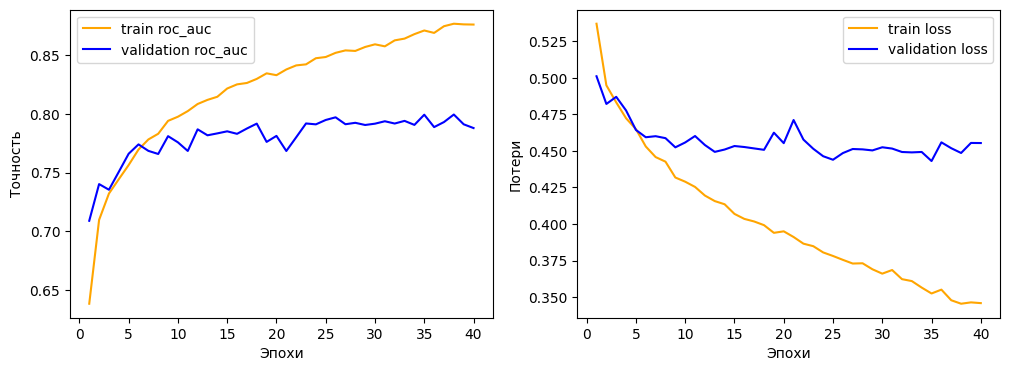

In [14]:
import matplotlib.pyplot as plt
auc_1 = history.history['auc_1']
val_auc_1 = history.history['val_auc_1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(auc_1) + 1)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, auc_1, 'b', label='train roc_auc', color='orange')
plt.plot(epochs, val_auc_1, 'b', label='validation roc_auc')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='train loss', color='orange')
plt.plot(epochs, val_loss, 'b', label='validation loss')
#plt.title('Потери на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.savefig('curves.png')
plt.show()

In [15]:
model.save('InceptionV3.keras')

In [16]:


val_generator = val_datagen.flow_from_directory(
        '/kaggle/working/val',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(val_generator)

Found 4000 images belonging to 2 classes.
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step


In [17]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(val_generator.classes, pred)

0.7997216530770193

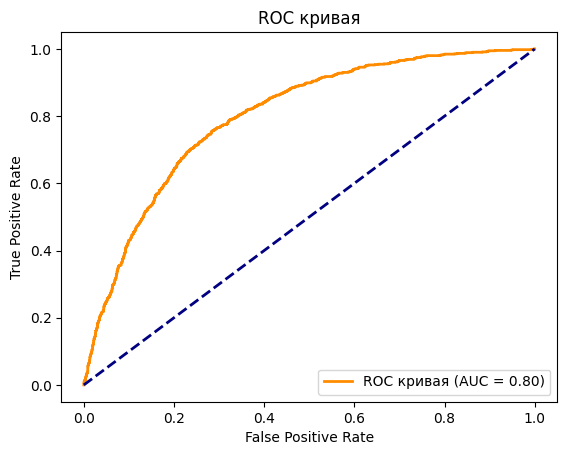

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(val_generator.classes, pred, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()


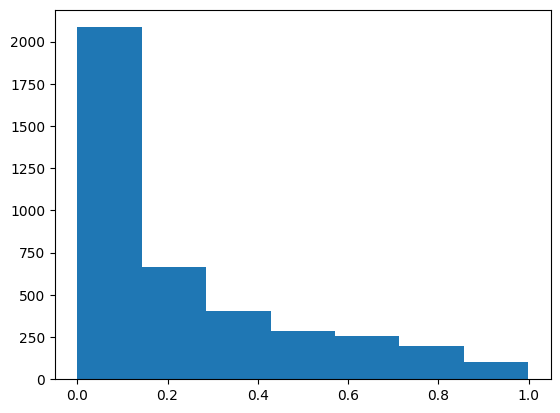

In [21]:
plt.hist(pred, bins=7)
plt.show()

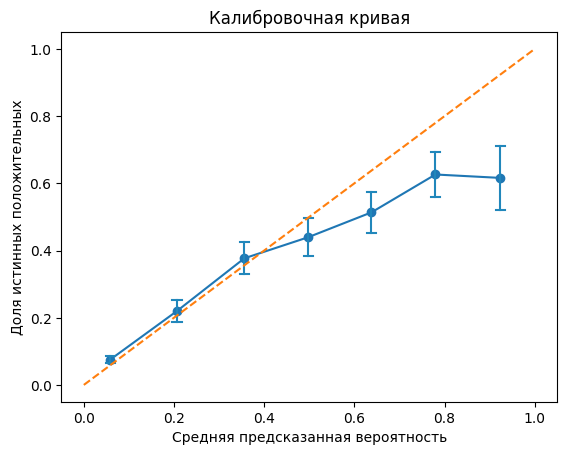

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

preds = np.squeeze(pred)
num_bins=7
prob_true, prob_pred = calibration_curve(val_generator.classes, preds, n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(pred)) :
        if threshold>pred[j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000, solver='lbfgs')
lr.fit(pred.reshape(-1,1), val_generator.classes)
print(lr.coef_)
print(lr.intercept_)

[[4.01718149]]
[-2.41674745]


In [25]:
import pickle


with open('calibration_InceptionV3.pkl','wb') as f:
    pickle.dump(lr,f)


In [26]:
print(lr.predict_proba(pred)[:, 1])

[0.16204083 0.11001483 0.10454046 ... 0.13948865 0.41803976 0.15242185]


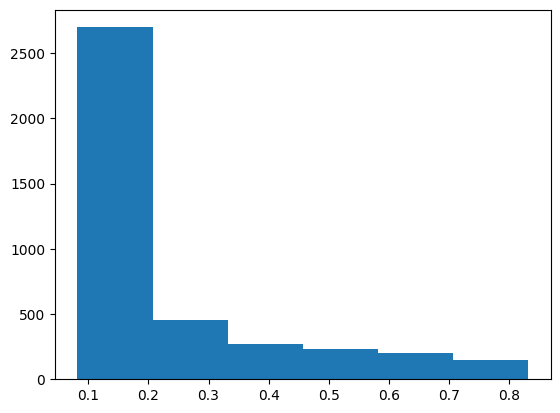

In [29]:
plt.hist(lr.predict_proba(pred)[:, 1], bins=6)
plt.show()

In [28]:
print(sum(lr.predict_proba(pred)[:, 1]>1-1/6))
print(sum(lr.predict_proba(pred)[:, 1]>1-1/5))

0
30


[0.10249622 0.37070254 0.50810811 0.61324042 0.6       ]
[0.11533992 0.28426324 0.49578556 0.68953341 0.81775348]


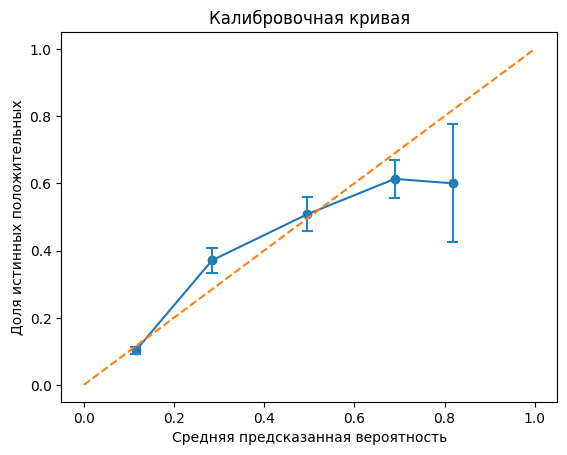

In [31]:
preds = np.squeeze(pred)
num_bins=5
prob_true, prob_pred = calibration_curve(val_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
print(prob_true)
print(prob_pred)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(lr.predict_proba(pred)[:, 1])) :
        if threshold>lr.predict_proba(pred)[:, 1][j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [32]:

test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(test_generator)


Found 2000 images belonging to 2 classes.
  1/100 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step


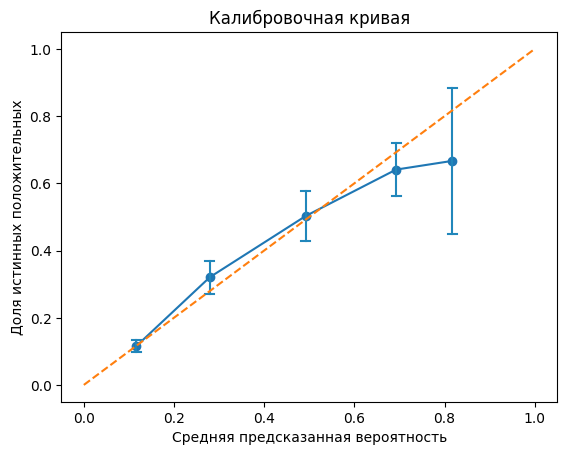

In [35]:

preds = np.squeeze(pred)
num_bins=5
prob_true, prob_pred = calibration_curve(test_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(lr.predict_proba(pred)[:, 1])) :
        if threshold>lr.predict_proba(pred)[:, 1][j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [36]:
print(sum(lr.predict_proba(pred)[:, 1]>1-1/6))
print(sum(lr.predict_proba(pred)[:, 1]>1-1/5))

0
18


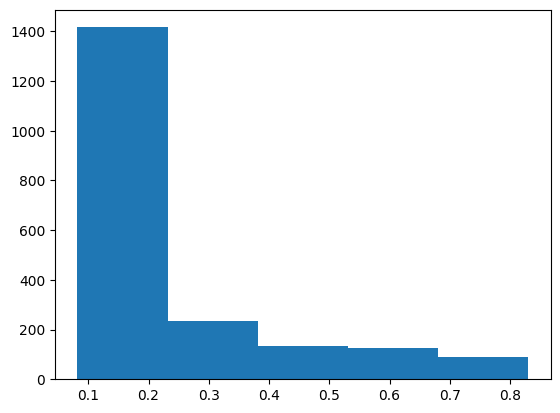

In [37]:
plt.hist(lr.predict_proba(pred)[:, 1], bins=5)
plt.show()

In [143]:
test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary',
        shuffle=False)


Found 2000 images belonging to 2 classes.


In [38]:
def predict(photos) :
    predictions=model.predict(photos)
    calibrated_probabilities=lr.predict_proba(predictions)[:, 1]
    return calibrated_probabilities

In [39]:
probas=predict(test_generator)

print(len(probas))

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step
2000


In [40]:
roc_auc_score(test_generator.classes, probas)

0.7804620390238176